# Importing Packages

In [75]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy.ndimage.interpolation import shift
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Importing  and Filtering the Data
## Training Data

In [85]:
dt_parse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%id %H-%M')

data = pd.read_csv('data/transformed/Simples_Geração_de_Energia_Dia_data_nordeste.csv', header=0, names=['date', 'value'], parse_dates=True, date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data.head()
example = data['value'].head(1000)

,date,value
0,2000-01-01 00:00:00,5350.7
1,2000-01-01 01:00:00,5190.9
2,2000-01-01 02:00:00,5069.5
3,2000-01-01 03:00:00,4895.0
4,2000-01-01 04:00:00,4780.6


## Value over times

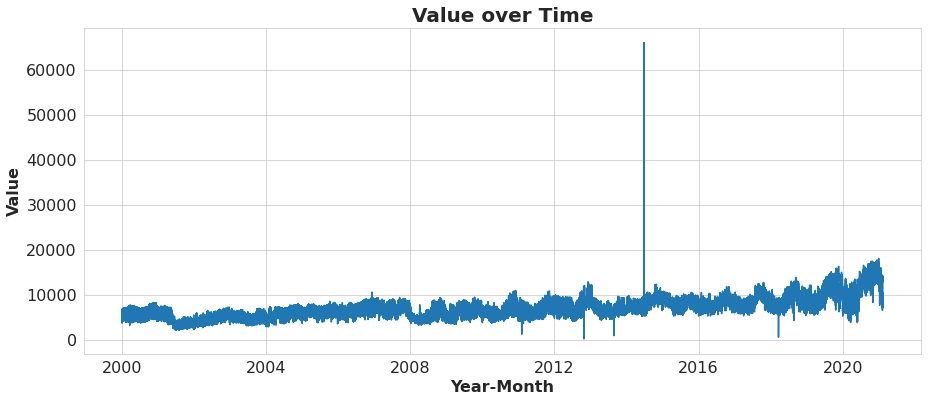

In [102]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data['date'], data['value'] )

ax.set_title('Value over Time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year-Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Value', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

## Test Data with one hundred first values

<AxesSubplot:ylabel='Density'>

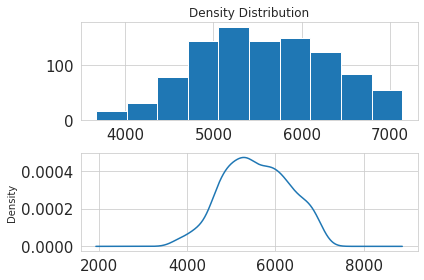

In [99]:
value = example
plt.figure(tight_layout=True)
plt.subplot(211)
value.hist()
plt.title('Density Distribution')
plt.subplot(212)
value.plot(kind='kde')